In [222]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor


In [199]:
# Read data
df = pd.read_csv("./cars-clean.csv")

In [200]:
ferrari = df[df["make"] == "Ferrari"].drop(["make"], axis = 1)
porsche = df[df["make"] == "Porsche"].drop(["make"], axis = 1)
bmw = df[df["make"] == "BMW"].drop(["make"], axis = 1)

In [240]:
df = porsche

In [202]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                                   sold_price
model                                        
910                                 2500000.0
959 Komfort                         1641653.0
935                                 1613000.0
934 Race Car                        1550000.0
Carrera GT                          1490709.5
...                                       ...
Panamera Turbo S Exclusive Series         NaN
Taycan 4S Cross Turismo                   NaN
Taycan GTS                                NaN
Taycan Turbo Cross Turismo                NaN
Turbo S Cabriolet                         NaN

[773 rows x 1 columns]


In [203]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [243]:
# Filter to models with more than min_observations
min_observations = 50
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [209]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [210]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

/var/folders/ss/ll1dr_c54xggkv2l3tpb_pvh0000gn/T/ipykernel_40668/3921177041.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



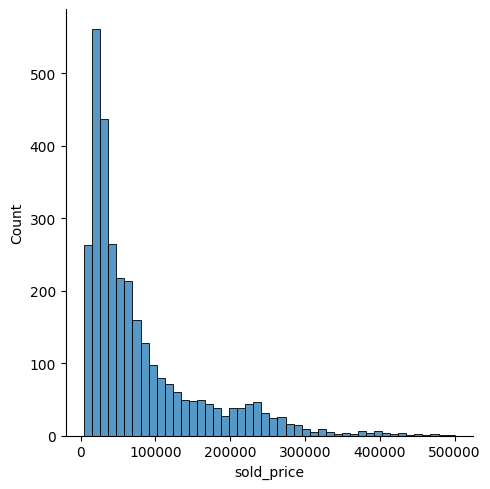

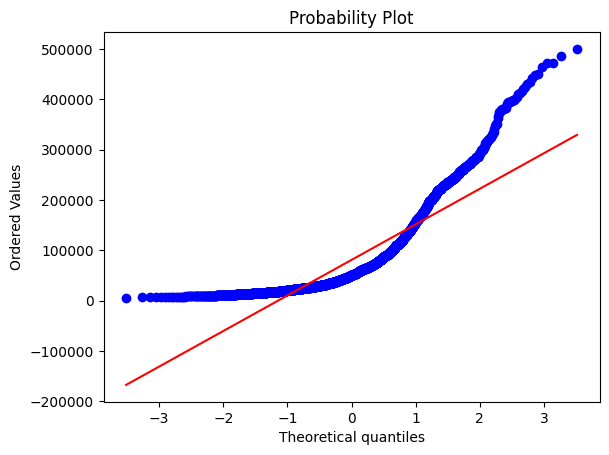

In [244]:
# Replace sold_price with bid_amount for the cars that were not sold
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>,
        <Axes: title={'center': 'sold_price'}>],
       [<Axes: title={'center': 'bid_amount'}>,
        <Axes: title={'center': 'bidders'}>,
        <Axes: title={'center': 'watchers'}>],
       [<Axes: title={'center': 'comments'}>, <Axes: >, <Axes: >]],
      dtype=object)

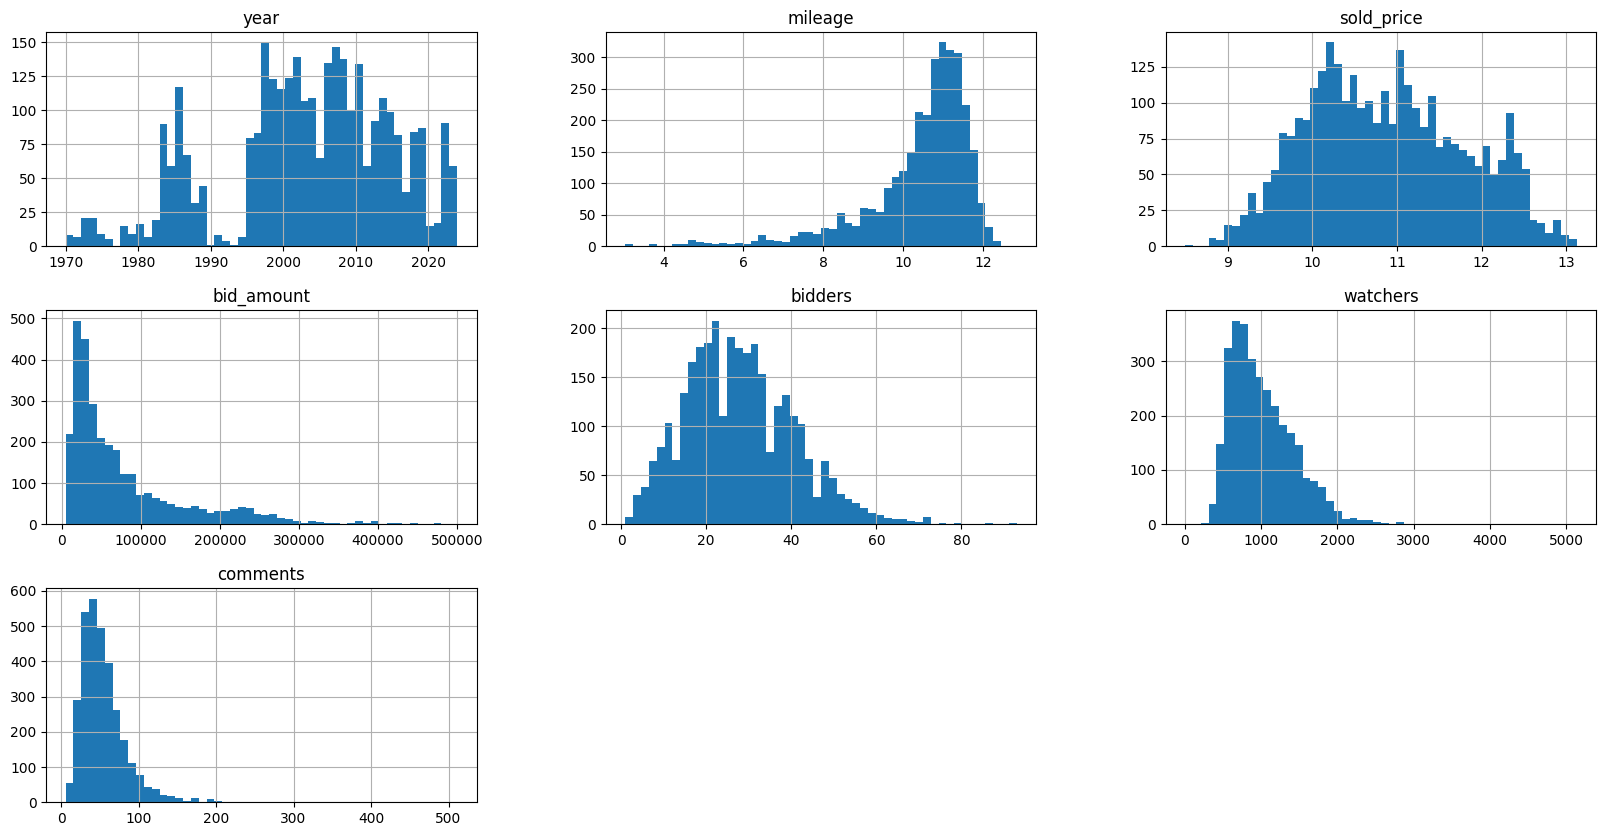

In [220]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [245]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


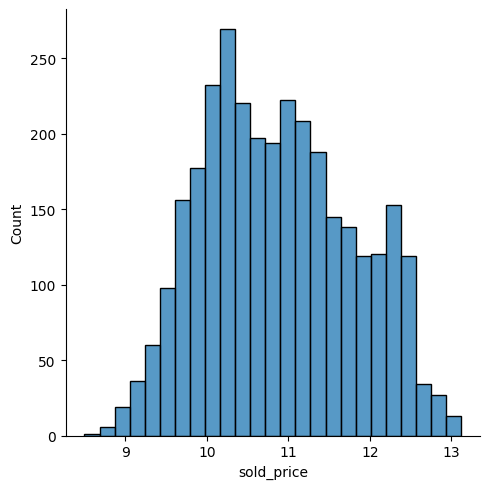

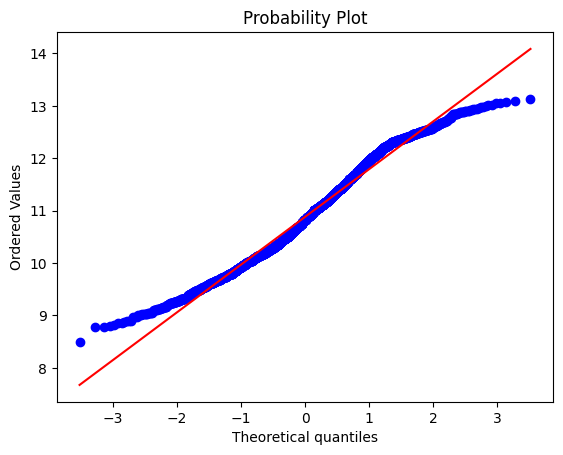

In [246]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [247]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,bidders,watchers,comments,days_since_end,W
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000
mean,2003.333862,10.416770,10.879305,80818.700095,27.880355,1019.043796,54.897175,395.449064,0.411279
std,11.638671,1.346007,0.919640,79630.745968,12.712947,435.276406,30.853359,232.337598,0.268197
min,1970.000000,3.044522,8.496990,4900.000000,1.000000,2.000000,6.000000,2.000000,0.130173
25%,1997.000000,9.998843,10.165506,25991.000000,19.000000,692.000000,35.000000,151.000000,0.189401
50%,2004.000000,10.778977,10.819778,50000.000000,27.000000,930.000000,48.000000,459.000000,0.279431
75%,2012.000000,11.289794,11.561716,105000.000000,36.000000,1267.000000,67.000000,599.000000,0.657412
max,2024.000000,12.847929,13.122363,500000.000000,93.000000,5134.000000,511.000000,734.000000,0.994460


In [248]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "bidders", "watchers", "comments", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
26,1996,911 Carrera 4S Coupe 6-Speed,11.141876,Black,manual,0.816460
38,1983,911SC Coupe,11.925042,Silver,manual,0.348967
43,2016,Cayenne Diesel,11.112463,White,automatic,0.347999
44,2018,911 Turbo S Cabriolet,8.853808,Silver,automatic,0.347999
58,2008,911 Carrera Cabriolet 6-Speed,10.799596,Blue,manual,0.347999
...,...,...,...,...,...,...
19994,1989,911 Speedster,9.903538,White,manual,0.598165
19995,2011,911 GT3,9.798183,Black,manual,0.596506
19996,2013,Cayenne Diesel,10.668979,White,automatic,0.596506
19998,2000,Boxster S 6-Speed,10.691968,Silver,manual,0.596506


In [249]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'911 Carrera 4 Cabriolet 6-Speed': 0, '911 Carrera 4S Coupe 6-Speed': 1, '911 Carrera Cabriolet': 2, '911 Carrera Cabriolet 6-Speed': 3, '911 Carrera Coupe': 4, '911 Carrera Coupe 6-Speed': 5, '911 Carrera Coupe G50': 6, '911 Carrera S Coupe': 7, '911 Carrera S Coupe 6-Speed': 8, '911 Carrera Targa': 9, '911 GT3': 10, '911 GT3 6-Speed': 11, '911 GT3 RS': 12, '911 GT3 RS Weissach': 13, '911 GT3 Touring 6-Speed': 14, '911 Speedster': 15, '911 Turbo': 16, '911 Turbo Cabriolet 6-Speed': 17, '911 Turbo Coupe': 18, '911 Turbo Coupe 6-Speed': 19, '911 Turbo S Cabriolet': 20, '911 Turbo S Coupe': 21, '911SC Coupe': 22, '914': 23, '944 5-Speed': 24, '944 Turbo': 25, 'Boxster': 26, 'Boxster 5-Speed': 27, 'Boxster S 6-Speed': 28, 'Cayenne Diesel': 29, 'Cayenne GTS': 30, 'Cayenne S': 31, 'Cayenne Turbo': 32, 'Cayenne Turbo S': 33, 'Cayman S 6-Speed': 34}
Color Mapping: {'Beige': 0, 'Black': 1, 'Blue': 2, 'Bronze': 3, 'Brown': 4, 'Burgundy': 5, 'Champagne': 6, 'Gold': 7, 'Gray': 8, 

,year,model,mileage,normalized_color,transmission,W
26,1996,1,11.141876,1,1,0.816460
38,1983,22,11.925042,17,1,0.348967
43,2016,29,11.112463,19,0,0.347999
44,2018,20,8.853808,17,0,0.347999
58,2008,3,10.799596,2,1,0.347999
...,...,...,...,...,...,...
19994,1989,15,9.903538,19,1,0.598165
19995,2011,10,9.798183,1,1,0.596506
19996,2013,29,10.668979,19,0,0.596506
19998,2000,28,10.691968,17,1,0.596506


In [251]:
# Fit Random Forest Regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = False)

car_model = RandomForestRegressor(n_estimators=150,random_state=33)
car_model.fit(X_train,y_train, sample_weight=X_train['W'])

# Features
# year	model	mileage	normalized_color	transmission
print('Random Forest Regressor Train Score is : ' ,  car_model.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model.score(X_test, y_test)) 

predicted = pd.DataFrame(car_model.predict(X_test), index=X_test.index, columns=['predicted'])
car_model.feature_importances_

Random Forest Regressor Train Score is :  0.990612420533363
Random Forest Regressor Test Score is :  0.9264471681412442


array([0.15425098, 0.7391019 , 0.07470894, 0.00807163, 0.00217566,
       0.02169088])

In [252]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
18699,2016,Cayenne S,11.251574,Blue,automatic,0.860708
18701,2000,911 Carrera Cabriolet 6-Speed,11.050906,Silver,manual,0.860708
18705,2015,Cayenne Diesel,10.668979,White,automatic,0.858320
18707,2016,Cayenne Turbo S,10.571343,Gray,automatic,0.858320
18710,1996,911 Carrera 4S Coupe 6-Speed,10.778977,Black,manual,0.858320
...,...,...,...,...,...,...
19994,1989,911 Speedster,9.903538,White,manual,0.598165
19995,2011,911 GT3,9.798183,Black,manual,0.596506
19996,2013,Cayenne Diesel,10.668979,White,automatic,0.596506
19998,2000,Boxster S 6-Speed,10.691968,Silver,manual,0.596506


In [253]:
# Analyze Resulst: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
X_analysis = pd.merge(X_analysis, predicted, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted = np.exp(X_analysis.predicted)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted
18699,19750.0,2016,Cayenne S,77000.0,Blue,automatic,0.860708,28731.009695
18701,24250.0,2000,911 Carrera Cabriolet 6-Speed,63000.0,Silver,manual,0.860708,22416.914514
18705,39250.0,2015,Cayenne Diesel,43000.0,White,automatic,0.858320,40324.708426
18707,68000.0,2016,Cayenne Turbo S,39000.0,Gray,automatic,0.858320,51359.713318
18710,171000.0,1996,911 Carrera 4S Coupe 6-Speed,48000.0,Black,manual,0.858320,95289.419865
...,...,...,...,...,...,...,...,...
19994,210000.0,1989,911 Speedster,20000.0,White,manual,0.598165,192274.651896
19995,198000.0,2011,911 GT3,18000.0,Black,manual,0.596506,191371.099114
19996,36000.0,2013,Cayenne Diesel,43000.0,White,automatic,0.596506,30836.668230
19998,19000.0,2000,Boxster S 6-Speed,44000.0,Silver,manual,0.596506,16148.216123


In [216]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
0 - 50000          331
50000 - 100000     136
100000 - 150000     61
200000 - 250000     37
150000 - 200000     34
250000 - 300000     16
Over 350000         10
300000 - 350000      6
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted'>

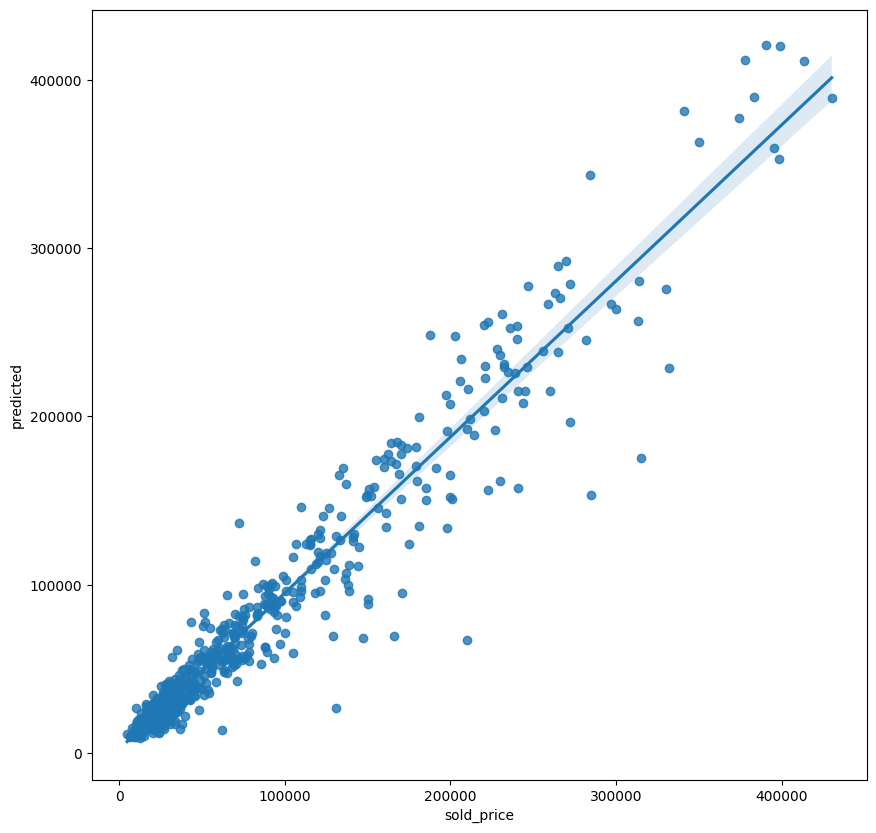

In [266]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted)

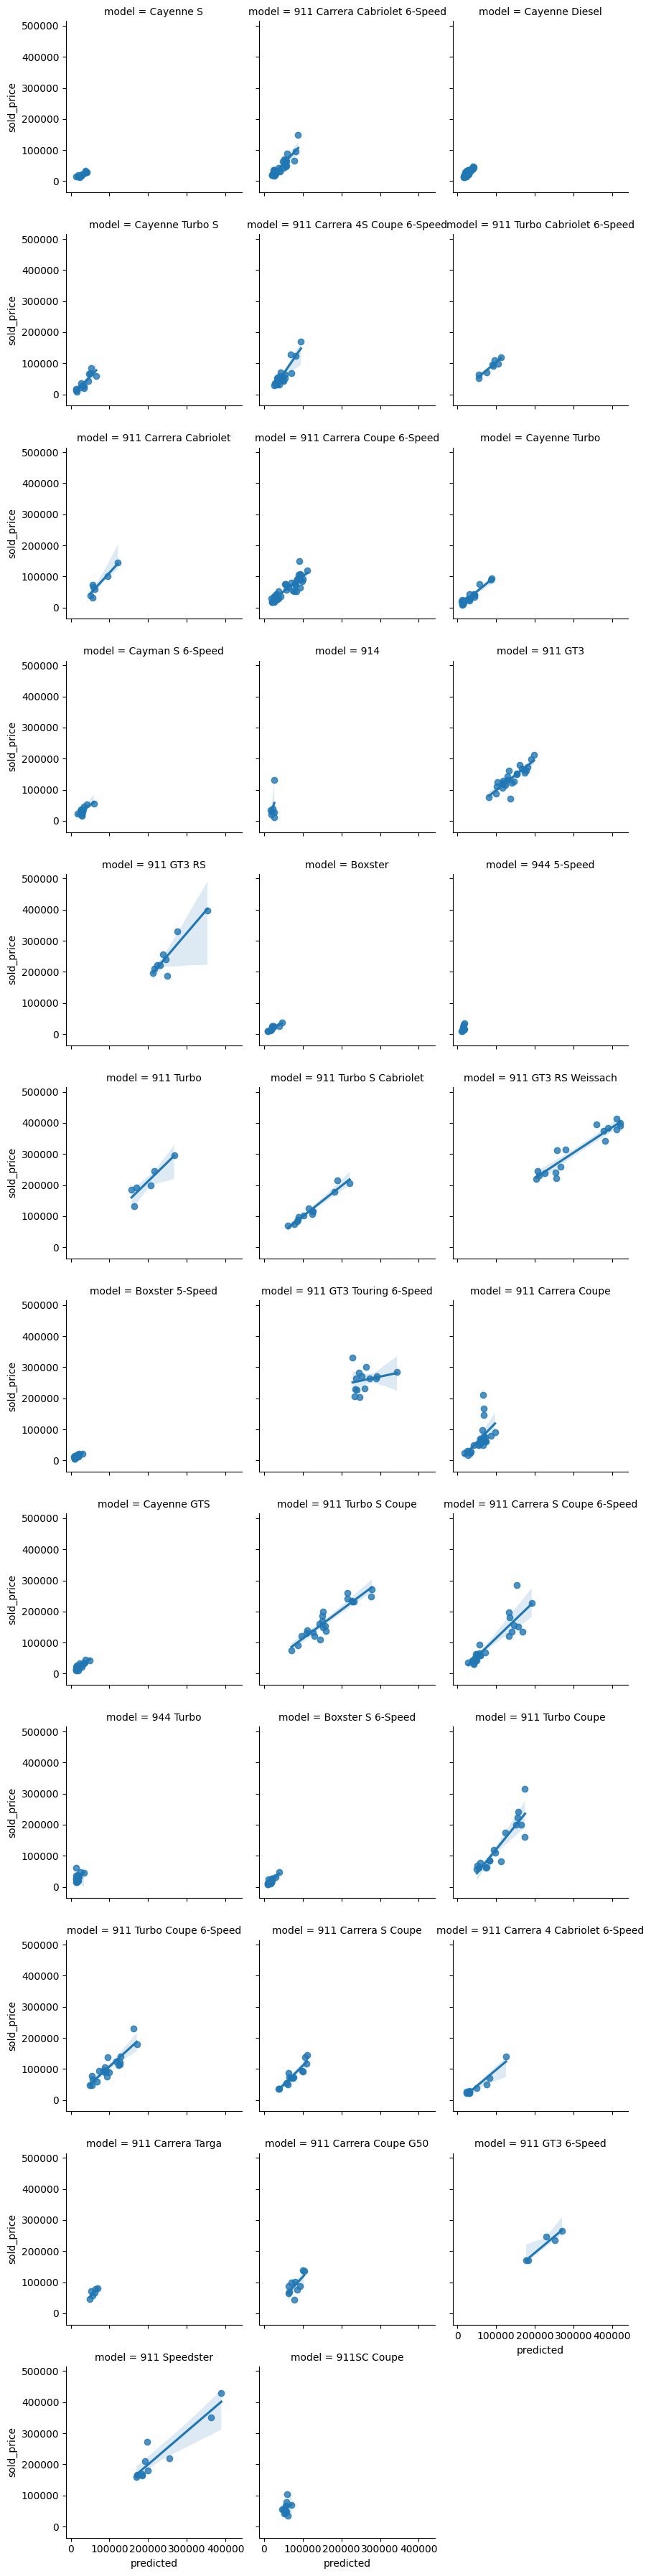

In [265]:
# Create the scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(sns.regplot, "predicted", "sold_price")